<a href="https://colab.research.google.com/github/BitKnitting/FitHome_Analysis/blob/master/notebooks/Exploring_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring K-means Clustering
I just finished collecting electricity readings.  Now it's time to play with them!

In [0]:
import pandas as pd
import numpy as np

In [0]:
# @title This function makes it easy to store .pkl.zip within GitHub.
from urllib.request import urlretrieve
def get_dataframe(url):
  file = 'file.zip'
  zipped_file = urlretrieve(url,file)
  filepath = '/content/'+file
  return pd.read_pickle(filepath)

In [189]:
df = get_dataframe('https://raw.githubusercontent.com/BitKnitting/FitHome_mongodb/master/data_results/aggregated.pkl.zip')
df.head()

,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


In [0]:
#################################################
# @title Interesting Data Stats
#################################################
def print_stats(df,title):
  print(title)
  print('**************************')
  print('Start date: {}'.format(df.index.min()))
  print('--------------------------')
  print('End date: {}'.format(df.index.max()))
  print('--------------------------')
  print('Shape: {}'.format(df.shape))
  print('--------------------------')
  print('Number of missing values:\n{}'.format(df.isnull().sum()))
  print('--------------------------')
  print('Summary Stats:\n {}'.format(df.describe()))
  print('--------------------------')


In [191]:
print_stats(df,'Aggregated READINGS')

Aggregated READINGS
**************************
Start date: 2019-11-26 14:28:31.823008060-08:00
--------------------------
End date: 2019-11-28 11:41:56.351084948-08:00
--------------------------
Shape: (51633, 3)
--------------------------
Number of missing values:
Pa    0
I     0
Pr    0
dtype: int64
--------------------------
Summary Stats:
                  Pa             I            Pr
count  51633.000000  51633.000000  51633.000000
mean     296.688705      6.924644    106.643199
std      371.955293      5.386997    148.249994
min        0.002880      1.845000      0.018880
25%       84.536000      2.621000     56.697280
50%      173.113600      4.613000     64.866560
75%      340.667200      9.960000     88.962240
max     4380.568000     62.135000   2779.302000
--------------------------


In [0]:
from matplotlib import pyplot as plt

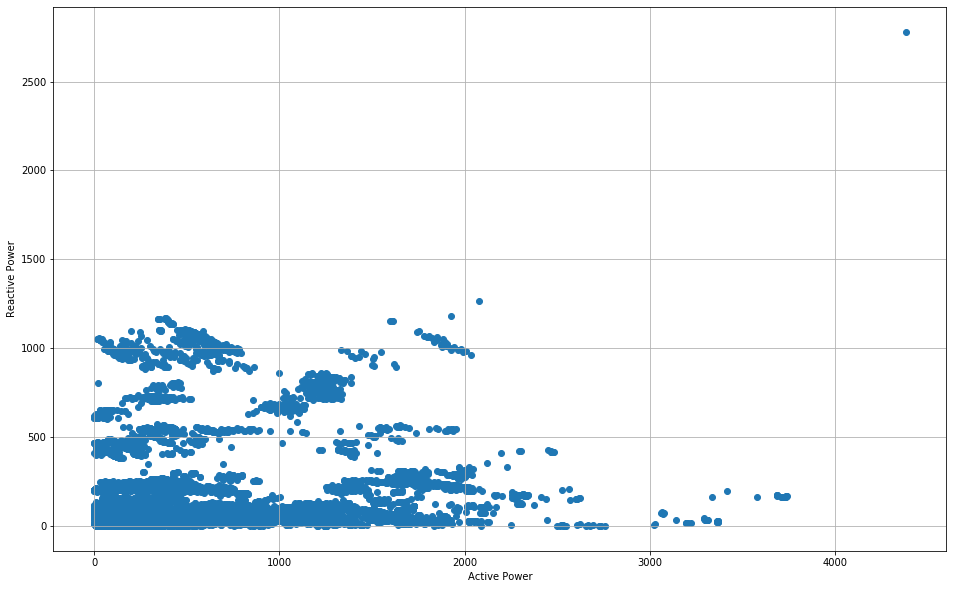

In [193]:
plt.figure(figsize=(16,10))
plt.xlabel('Active Power')
plt.ylabel('Reactive Power')
plt.grid(True)
plt.scatter(df['Pa'],df['Pr'])

There appears to be an outlier

In [194]:
# @title check out the outlier
df[df['Pr'] > 2500]


,Pa,I,Pr
timestamp,,,
2019-11-26 16:50:18.921397924-08:00,4380.568,62.135,2779.302


Readings are going along, and then SPIKE! Which could be valid.  But it does mess up the rest of the readings during analysis so we'll treat it as an outlier to be removed.

In [196]:
df_scatter = df.drop(df[df['Pr'] > 2500].index)
df_scatter.shape

(51632, 3)

There are less rows in df_scatter.

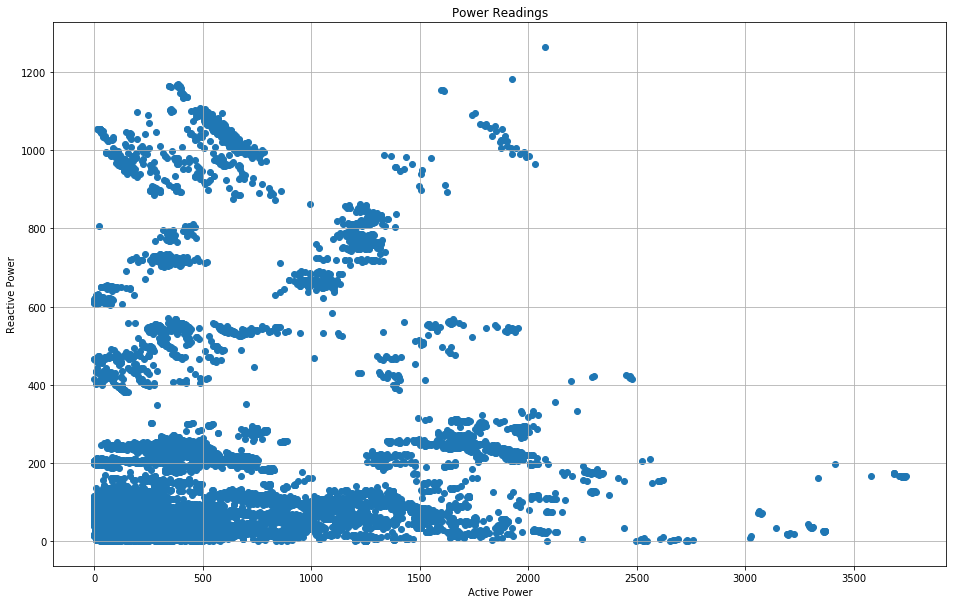

In [197]:
plt.figure(figsize=(16,10))
plt.xlabel('Active Power')
plt.ylabel('Reactive Power')
plt.title('Power Readings')
plt.grid(True)
plt.scatter(df_scatter['Pa'],df_scatter['Pr'])

hmmmn... not sure how well this data clusters....

# Optimal Cluster Size
Moving right along...What's the optimal cluster size?  Given we haven't done this before, we'll be using the method given in _[Tutorial: How to determine the optimal number of clusters for k-means clustering](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)_

## Scaling Data
The first thing we'll do is use [MinMaxScaler](https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) to scale the samples.  MinMaxScaler is within scikit-learn.  Input is typically a numpy array (not a pandas dataframe).

In [198]:
# @title scale from 0 to 1
scaler = MinMaxScaler()
display(df_scatter.head())
df_scaled = df_scatter.copy()
display(df_scatter.head())
df_scaled[['Pa','Pr']] = scaler.fit_transform(df_scaled[['Pa','Pr']])
display(df_scatter.head())
df_scaled = df_scaled.drop(['I'],axis='columns')



,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


In [199]:
df_scaled.head()

,Pa,Pr
timestamp,,
2019-11-26 14:28:31.823008060-08:00,0.140583,0.023089
2019-11-26 14:28:36.074999094-08:00,0.154174,0.023824
2019-11-26 14:28:39.270513058-08:00,0.151251,0.024099
2019-11-26 14:28:42.420862913-08:00,0.153141,0.025152
2019-11-26 14:28:45.567107916-08:00,0.150268,0.024534


In [200]:
df_scatter.head()

,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


Looking at the dataframe versus numpy array, Pa is values[:,0].  Pr is values[:,1]

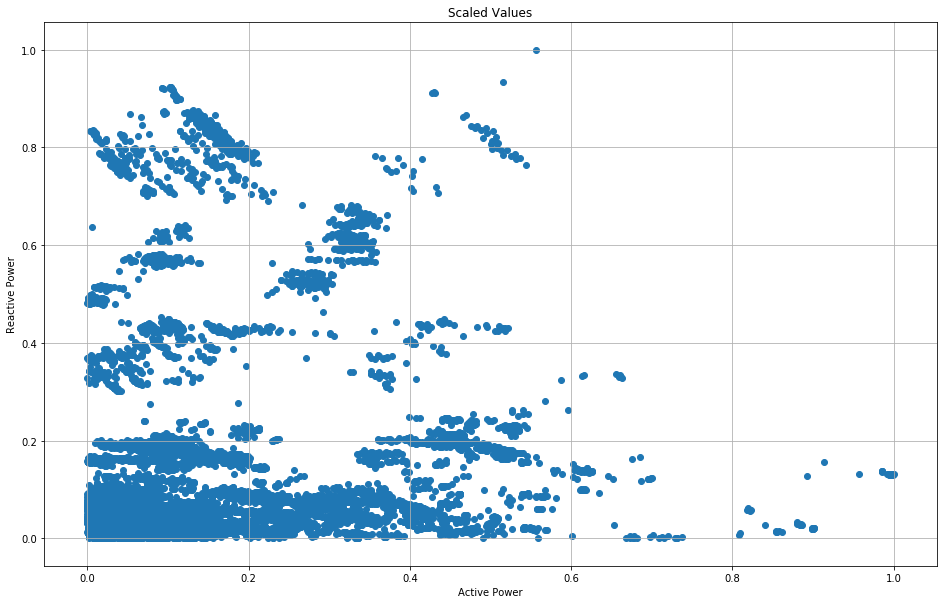

In [201]:
plt.figure(figsize=(16,10))
plt.xlabel('Active Power')
plt.ylabel('Reactive Power')
plt.title('Scaled Values')
plt.grid(True)
plt.scatter(df_scaled['Pa'],df_scaled['Pr'])

In [0]:
from sklearn.cluster import KMeans

In [203]:
df_scatter.head()

,Pa,I,Pr
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,525.7321,12.196,29.20960
2019-11-26 14:28:36.074999094-08:00,576.5564,11.781,30.13888
2019-11-26 14:28:39.270513058-08:00,565.6256,11.851,30.48672
2019-11-26 14:28:42.420862913-08:00,572.6960,11.886,31.81792
2019-11-26 14:28:45.567107916-08:00,561.9494,11.970,31.03616


In [0]:
# @title Figure out the SSE
SSE = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_scaled)
    SSE.append(km.inertia_)

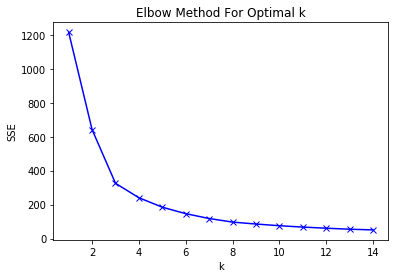

In [205]:
plt.plot(K, SSE, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()

# Optimal K
From the above plot, the elbow is at k=3.

In [206]:
km = KMeans(n_clusters=3)
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
# @title Figure out which cluster each row is in.
y_predicted = km.fit_predict(df_scaled)
df_scaled['cluster'] = y_predicted



In [208]:
km.cluster_centers_

array([[0.05488721, 0.06091022],
       [0.15667873, 0.5870267 ],
       [0.39103485, 0.10142802]])

In [209]:
df_scaled.head()

,Pa,Pr,cluster
timestamp,,,
2019-11-26 14:28:31.823008060-08:00,0.140583,0.023089,0
2019-11-26 14:28:36.074999094-08:00,0.154174,0.023824,0
2019-11-26 14:28:39.270513058-08:00,0.151251,0.024099,0
2019-11-26 14:28:42.420862913-08:00,0.153141,0.025152,0
2019-11-26 14:28:45.567107916-08:00,0.150268,0.024534,0


In [0]:
df_scaled_1 = df_scaled[df_scaled['cluster'] == 0]
df_scaled_2 = df_scaled[df_scaled['cluster'] == 1]
df_scaled_3 = df_scaled[df_scaled['cluster'] == 2]


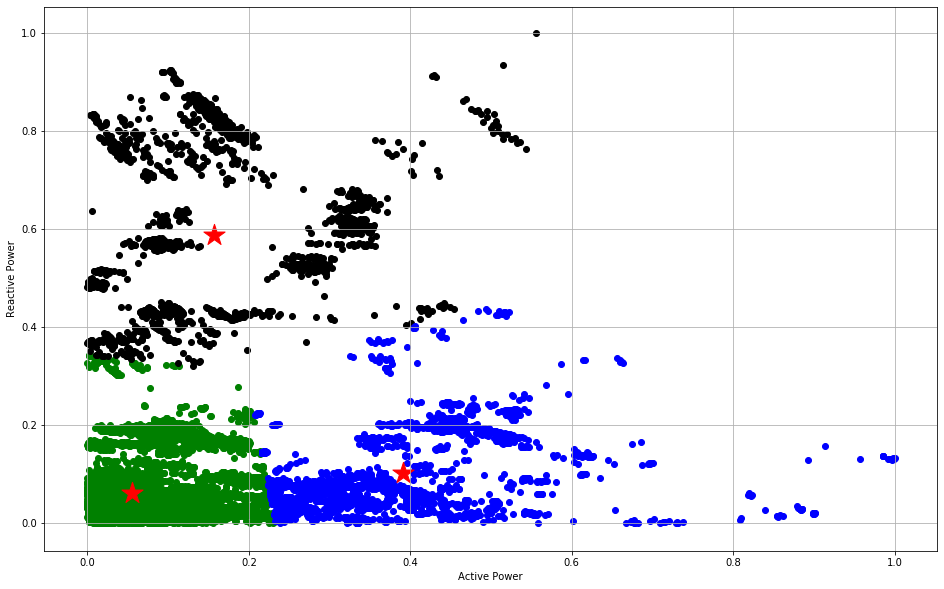

In [211]:
plt.figure(figsize=(16,10))
plt.xlabel('Active Power')
plt.ylabel('Reactive Power')
plt.grid(True)
plt.scatter(df_scaled_1['Pa'],df_scaled_1['Pr'],color='green')
plt.scatter(df_scaled_2['Pa'],df_scaled_2['Pr'],color='black')
plt.scatter(df_scaled_3['Pa'],df_scaled_3['Pr'],color='blue')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=500,marker='*',color='red')


In [216]:
df_scatter['cluster'] = df_scaled['cluster']
df_scatter_2 = df_scatter[df_scatter['cluster'] == 1]
df_scatter_2.describe()


,Pa,I,Pr,cluster
count,2054.000000,2054.000000,2054.000000,2054.0
mean,585.924151,15.610470,742.175092,1.0
std,422.537939,4.783489,202.448403,0.0
min,0.020800,7.560000,405.453700,1.0
25%,303.303000,11.356500,547.728825,1.0
50%,423.160950,14.823000,719.823500,1.0
75%,756.874800,17.903750,949.370350,1.0
max,2079.410000,40.054000,1264.282000,1.0


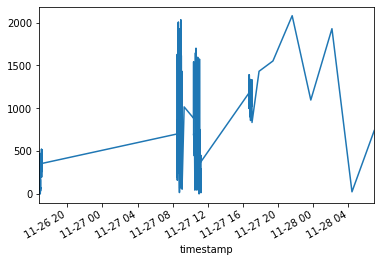

In [217]:
df_scatter_2['Pa'].plot()

In [218]:
df_scatter_1 = df_scatter[df_scatter['cluster'] == 0]
df_scatter_1.describe()

,Pa,I,Pr,cluster
count,46448.000000,46448.000000,46448.000000,46448.0
mean,205.261035,5.744023,77.025427,0.0
std,162.793325,3.961495,55.303655,0.0
min,0.002880,1.845000,0.018880,0.0
25%,77.661040,2.538000,54.972560,0.0
50%,162.240300,4.140000,64.455840,0.0
75%,279.949500,8.253000,79.224720,0.0
max,866.354800,32.634000,433.896600,0.0


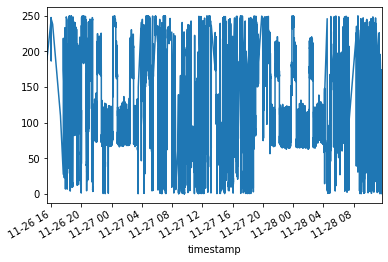

In [223]:
df_scatter_1['Pa'][df_scatter_1['Pa'] < 250].plot()